# Import Libraries

In [1]:
from tensorflow import keras
from keras.layers import Activation, Dense, Dropout
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import backend as K

import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import random
import gym

import matplotlib.pyplot as plt
from matplotlib import animation

/Users/r/Desktop/miniforge3/envs/tf_env/lib/python3.10/site-packages/gym/envs/registration.py:423: UserWarning: WARN: Custom namespace `ALE` is being overridden by namespace `ALE`. If you are developing a plugin you shouldn't specify a namespace in `register` calls. The namespace is specified through the entry point package metadata.
  logger.warn(


# Define ActorCritic Network

In [2]:
class ActorNetwork(keras.Model):
    def __init__(self, n_actions, h_dims = [128, 64], filename = 'actor'):
        super(ActorNetwork, self).__init__()
        self.h_dims = h_dims
        self.n_actions = n_actions
        self.filename = filename
        
        self.d1 = Dense(self.h_dims[0], activation = 'relu')
        self.d2 = Dense(self.h_dims[1], activation = 'relu')
        self.p_out = Dense(n_actions, activation = 'softmax')
        
    def call(self, state):
        x = self.d1(state)
        x = self.d2(x)
        
        p = self.p_out(x)
        
        return p
    
class CriticNetwork(keras.Model):
    def __init__(self, h_dims = [128, 64], filename = 'critic'):
        super(CriticNetwork, self).__init__()
        self.h_dims = h_dims
        self.filename = filename
        
        self.d1 = Dense(self.h_dims[0], activation = 'relu')
        self.d2 = Dense(self.h_dims[1], activation = 'relu')
        self.v_out = Dense(1, activation = None)
        
    def call(self, state):
        x = self.d1(state)
        x = self.d2(x)
        v = self.v_out(x)
        
        return v

# Define Agent

In [3]:
def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):
    
    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)

class Agent():
    def __init__(self, 
                 lr = 1e-3, 
                 gamma = 0.99,
                 n_actions = 2, 
                 **kwargs):
        
        self.lr = lr
        self.gamma = gamma
        self.n_actions = n_actions
        self.action = None
        self.action_space = [_ for _ in range(n_actions)]
        
        self.a_net  = ActorNetwork(n_actions = n_actions)
        self.a_net.compile(optimizer = Adam(learning_rate = self.lr))
        self.c_net  = CriticNetwork()
        self.c_net.compile(optimizer = Adam(learning_rate = self.lr))
        
        self.step = 0
    
    def select_action(self, observation, is_training = True):
        state = tf.convert_to_tensor(np.array([observation], copy=False, dtype = np.float32))
        
        act_dist = self.a_net(state, training = is_training)
        
        act_sample = tfp.distributions.Categorical(probs = act_dist)
        self.action = act_sample.sample()

        return self.action.numpy()[0]
        
    def learn(self, c_state, reward, n_state, done):
        
        c_state = tf.convert_to_tensor([c_state], dtype = tf.float32)
        n_state = tf.convert_to_tensor([n_state], dtype = tf.float32)
        reward  = tf.convert_to_tensor(reward, dtype = tf.float32)

        with tf.GradientTape() as a_tape, tf.GradientTape() as c_tape:
            p     = self.a_net(c_state)
            c_val = self.c_net(c_state)
            n_val = self.c_net(n_state)
            c_val = tf.squeeze(c_val)
            n_val = tf.squeeze(n_val)
            
            act_p = tfp.distributions.Categorical(probs = p)
            log_p = act_p.log_prob(self.action)
            
            #c_val = estimated value 
            #reward + self.gamma*n_val*(1 - done) = better estimated value = target
            #we hope that target - c_val => 0 => indicate better estimate
            #so, we minimise the c_loss
            
            delta = reward + self.gamma*n_val*(1 - done) - c_val
            a_loss = -log_p*delta
            c_loss = delta**2
            
            total_loss = a_loss + c_loss
            
        a_gradient = a_tape.gradient(total_loss, self.a_net.trainable_variables)
        c_gradient = c_tape.gradient(total_loss, self.c_net.trainable_variables)
        self.a_net.optimizer.apply_gradients(zip(a_gradient, 
                                                 self.a_net.trainable_variables))
        self.c_net.optimizer.apply_gradients(zip(c_gradient, 
                                                 self.c_net.trainable_variables))

    def train(self, n_episodes = 1800, env_max_step = 500, windows = 20, is_load_model = False):
        
        #setup environment
        env = gym.make('CartPole-v0')
        env._max_episode_steps = env_max_step
        
        score_hist = []
        score_avg_hist = []        
        score_best = -np.inf
        
        if is_load_model:
            self.load_models()
            
        for episode in range(n_episodes):
            
            obs = env.reset()
            rewards = []
            values = []
            
            score = 0
            done = False
            step = 0
            while not done:
                #select action
                action = self.select_action(obs)
                
                #interact with the environment
                obs_, reward, done, info = env.step(action)
                
                #update score 
                score += reward
                
                #learn               
                self.learn(obs, reward, obs_, done)
                
                #update observation
                obs = obs_
                
                step += 1
            
            score_hist.append(score)
            score_avg_hist.append(np.mean(score_hist[-windows:]))
            
            if score_avg_hist[-1] > score_best and score > score_best and episode > windows:
                score_best = score_avg_hist[-1]
                self.save_models()
            
            print(f'epidsode: {episode}, score: {score}, avg_score: {score_avg_hist[-1]}, best_score: {score_best}')

        env.close()
        
    def demo(self, env_max_step = 500, is_save_gif = False):
        #setup environment
        env = gym.make('CartPole-v0')
        env._max_episode_steps = env_max_step
        
        #reset environment 
        obs = env.reset()
    
        score = 0
        done = False
        
        #load model
        self.load_models()
        
        frames = []
        while not done:
            #select action
            action = self.select_action(obs, is_training = False)
            
            #interact with the environment
            obs_, reward, done, info = env.step(action)
            
            #update score 
            score += reward
            
            #update observation
            obs = obs_
            if is_save_gif:
                frames.append(env.render(mode="rgb_array"))
            else:
                env.render()

        print(f'score: {score}')
        env.close()
        save_frames_as_gif(frames)
        
    def save_models(self):
        self.a_net.save_weights(self.a_net.filename)
        self.c_net.save_weights(self.c_net.filename)
        print("... saving model ...")
        
    def load_models(self):
        self.a_net.load_weights(self.a_net.filename)
        self.c_net.load_weights(self.c_net.filename)
        print('... loading models ...')

# Start Learning

In [4]:
n_episode = 500
agent = Agent()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-11-08 17:24:39.896227: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-08 17:24:39.896476: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
agent.train(n_episodes = n_episode, env_max_step = 500, is_load_model = False)

# Demo

/Users/r/Desktop/miniforge3/envs/tf_env/lib/python3.10/site-packages/gym/envs/registration.py:568: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


... loading models ...


MovieWriter imagemagick unavailable; using Pillow instead.


score: 500.0


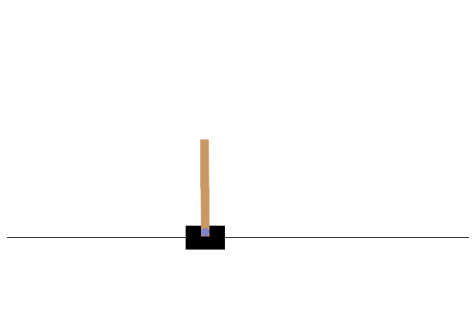

In [5]:
agent.demo(is_save_gif = True)